In this project we are going to train a vq-vae model to generate images of the anime faces dataset. 

In [1]:
from __future__ import print_function


import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import savgol_filter

from six.moves import xrange

import umap

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
import torch.optim as optim

import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torchvision.utils import make_grid

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
anime_path = "../data/anime_face"

In [4]:
dataset = datasets.ImageFolder(
    root=anime_path,
    transform=transforms.Compose([
        transforms.Resize((64, 64)),
        transforms.ToTensor(),
    ])
)

train_size = int(0.8 * len(dataset))
val_size = (len(dataset) - train_size) // 2
test_size = len(dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=True)

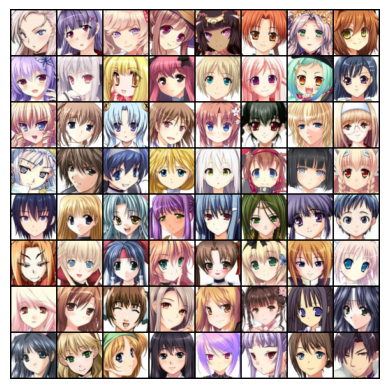

In [5]:
def show_images(images):
    images = make_grid(images, nrow=8)
    plt.imshow(images.permute(1, 2, 0))
    plt.axis("off")
    plt.show()
    
images, _ = next(iter(train_loader))
show_images(images)

In [6]:
class VectorQuantizer(nn.Module):
    def __init__(self, num_embeddings, embedding_dim, commitment_cost):
        super(VectorQuantizer, self).__init__()
        
        self._embedding_dim = embedding_dim
        self._num_embeddings = num_embeddings
        
        self._embedding = nn.Embedding(self._num_embeddings, self._embedding_dim)
        self._embedding.weight.data.uniform_(-1/self._num_embeddings, 1/self._num_embeddings)
        self._commitment_cost = commitment_cost

    def forward(self, inputs):
        inputs = inputs.permute(0, 2, 3, 1).contiguous()
        input_shape = inputs.shape
        
        flat_input = inputs.view(-1, self._embedding_dim)
        
        distances = (torch.sum(flat_input**2, dim=1, keepdim=True) 
                    + torch.sum(self._embedding.weight**2, dim=1)
                    - 2 * torch.matmul(flat_input, self._embedding.weight.t()))
            
        encoding_indices = torch.argmin(distances, dim=1).unsqueeze(1)
        encodings = torch.zeros(encoding_indices.shape[0], self._num_embeddings, device=inputs.device)
        encodings.scatter_(1, encoding_indices, 1)
        
        quantized = torch.matmul(encodings, self._embedding.weight).view(input_shape)
        
        e_latent_loss = F.mse_loss(quantized.detach(), inputs)
        q_latent_loss = F.mse_loss(quantized, inputs.detach())
        loss = q_latent_loss + self._commitment_cost * e_latent_loss
        
        quantized = inputs + (quantized - inputs).detach()
        avg_probs = torch.mean(encodings, dim=0)
        perplexity = torch.exp(-torch.sum(avg_probs * torch.log(avg_probs + 1e-10)))
        
        return loss, quantized.permute(0, 3, 1, 2).contiguous(), perplexity, encodings

In [7]:
class Residual(nn.Module):
    def __init__(self, in_channels, num_hiddens, num_residual_hiddens):
        super(Residual, self).__init__()
        self._block = nn.Sequential(
            nn.ReLU(True),
            nn.Conv2d(in_channels=in_channels,
                      out_channels=num_residual_hiddens,
                      kernel_size=3, stride=1, padding=1, bias=False),
            nn.ReLU(True),
            nn.Conv2d(in_channels=num_residual_hiddens,
                      out_channels=num_hiddens,
                      kernel_size=1, stride=1, bias=False)
        )
    
    def forward(self, x):
        return x + self._block(x)


class ResidualStack(nn.Module):
    def __init__(self, in_channels, num_hiddens, num_residual_layers, num_residual_hiddens):
        super(ResidualStack, self).__init__()
        self._num_residual_layers = num_residual_layers
        self._layers = nn.ModuleList([Residual(in_channels, num_hiddens, num_residual_hiddens)
                             for _ in range(self._num_residual_layers)])

    def forward(self, x):
        for i in range(self._num_residual_layers):
            x = self._layers[i](x)
        return F.relu(x)

In [8]:
class Encoder(nn.Module):
    def __init__(self, in_channels, num_hiddens, num_residual_layers, num_residual_hiddens):
        super(Encoder, self).__init__()

        self._conv_1 = nn.Conv2d(in_channels=in_channels,
                                 out_channels=num_hiddens//2,
                                 kernel_size=4,
                                 stride=2, padding=1)
        self._conv_2 = nn.Conv2d(in_channels=num_hiddens//2,
                                 out_channels=num_hiddens,
                                 kernel_size=4,
                                 stride=2, padding=1)
        self._conv_3 = nn.Conv2d(in_channels=num_hiddens,
                                 out_channels=num_hiddens,
                                 kernel_size=3,
                                 stride=1, padding=1)
        self._residual_stack = ResidualStack(in_channels=num_hiddens,
                                             num_hiddens=num_hiddens,
                                             num_residual_layers=num_residual_layers,
                                             num_residual_hiddens=num_residual_hiddens)

    def forward(self, inputs):
        x = self._conv_1(inputs)
        x = F.relu(x)
        
        x = self._conv_2(x)
        x = F.relu(x)
        
        x = self._conv_3(x)
        return self._residual_stack(x)

In [9]:
class Decoder(nn.Module):
    def __init__(self, in_channels, num_hiddens, num_residual_layers, num_residual_hiddens):
        super(Decoder, self).__init__()
        
        self._conv_1 = nn.Conv2d(in_channels=in_channels,
                                 out_channels=num_hiddens,
                                 kernel_size=3, 
                                 stride=1, padding=1)
        
        self._residual_stack = ResidualStack(in_channels=num_hiddens,
                                             num_hiddens=num_hiddens,
                                             num_residual_layers=num_residual_layers,
                                             num_residual_hiddens=num_residual_hiddens)
        
        self._conv_trans_1 = nn.ConvTranspose2d(in_channels=num_hiddens, 
                                                out_channels=num_hiddens//2,
                                                kernel_size=4, 
                                                stride=2, padding=1)
        
        self._conv_trans_2 = nn.ConvTranspose2d(in_channels=num_hiddens//2, 
                                                out_channels=3,
                                                kernel_size=4, 
                                                stride=2, padding=1)

    def forward(self, inputs):
        x = self._conv_1(inputs)
        
        x = self._residual_stack(x)
        
        x = self._conv_trans_1(x)
        x = F.relu(x)
        
        return self._conv_trans_2(x)

In [10]:
batch_size = 256
num_training_updates = 5

num_hiddens = 128
num_residual_hiddens = 32
num_residual_layers = 2

embedding_dim = 64
num_embeddings = 512

commitment_cost = 0.25

decay = 0.99

learning_rate = 1e-3

In [11]:
class Model(nn.Module):
    def __init__(self, num_hiddens, num_residual_layers, num_residual_hiddens, 
                 num_embeddings, embedding_dim, commitment_cost, decay=0):
        super(Model, self).__init__()
        
        self._encoder = Encoder(3, num_hiddens,
                                num_residual_layers, 
                                num_residual_hiddens)
        self._pre_vq_conv = nn.Conv2d(in_channels=num_hiddens, 
                                      out_channels=embedding_dim,
                                      kernel_size=1, 
                                      stride=1)

        self._vq_vae = VectorQuantizer(num_embeddings, embedding_dim,
                                           commitment_cost)
        self._decoder = Decoder(embedding_dim,
                                num_hiddens, 
                                num_residual_layers, 
                                num_residual_hiddens)

    def forward(self, x):
        z = self._encoder(x)
        z = self._pre_vq_conv(z)
        loss, quantized, perplexity, _ = self._vq_vae(z)
        x_recon = self._decoder(quantized)

        return loss, x_recon, perplexity

In [12]:
model = Model(num_hiddens, num_residual_layers, num_residual_hiddens, num_embeddings, embedding_dim, commitment_cost, decay).to(device)

In [13]:
optimizer = optim.Adam(model.parameters(), lr=learning_rate, amsgrad=False)

In [14]:
def train(data_loader, model, optimizer):
    model.train()
    
    train_loss = 0
    for x in data_loader:
        x = x[0].to(device)
        optimizer.zero_grad()

        loss, _, _ = model(x)
        
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
    return train_loss

def validate(data_loader, model):
    model.eval()
    
    val_loss = 0
    for x in data_loader:
        x = x[0].to(device)
        
        loss, _, _ = model(x)
        
        val_loss += loss.item()
    return val_loss

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[0/5] Train loss: 0.011822. Val loss: 0.000019


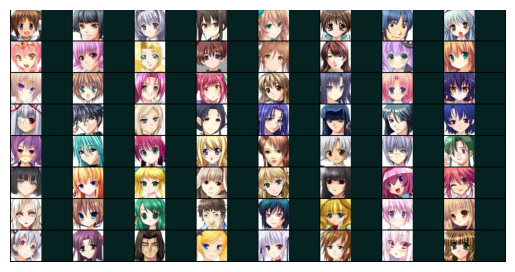

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[1/5] Train loss: 0.000091. Val loss: 0.000007


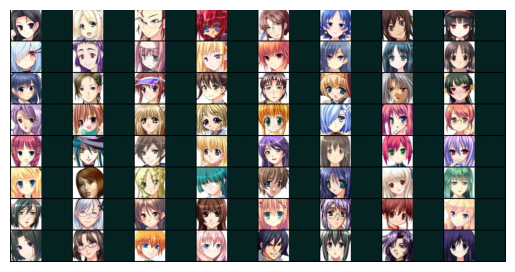

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[2/5] Train loss: 0.000079. Val loss: 0.000005


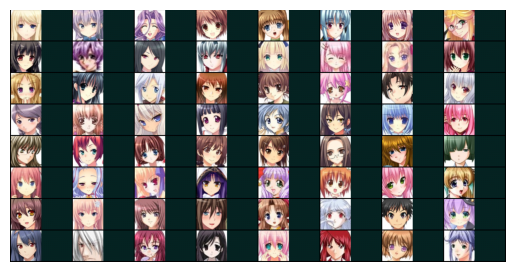

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[3/5] Train loss: 0.000027. Val loss: 0.000002


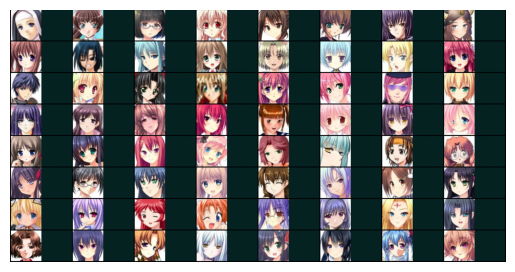

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[4/5] Train loss: 0.000016. Val loss: 0.000001


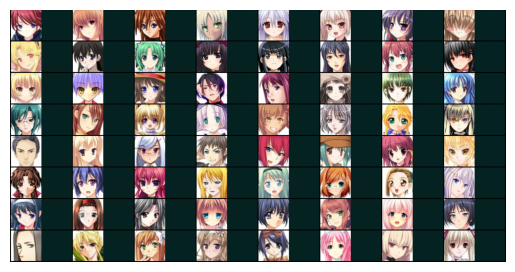

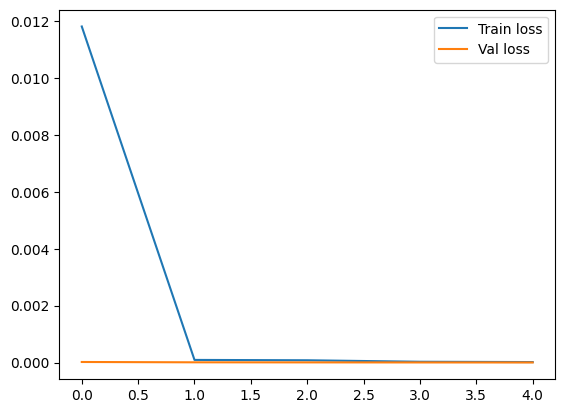

In [15]:
train_losses = []
val_losses = []

train_reconstructions_losses = []
val_reconstructions_losses = []

for i in xrange(num_training_updates):
    x = next(iter(train_loader))[0].to(device)
    
    train_loss = train(train_loader, model, optimizer)
    val_loss = validate(val_loader, model)
    
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    
    reconstructions_loss = F.mse_loss(model(x)[1], x)
    train_reconstructions_losses.append(reconstructions_loss)
    
    val = next(iter(val_loader))[0].to(device)
    reconstructions_loss = F.mse_loss(model(val)[1], val)
    val_reconstructions_losses.append(reconstructions_loss)
    
    print("[%d/%d] Train loss: %f. Val loss: %f" % (i, num_training_updates, train_loss, val_loss))
    
    _, x_recon, _ = model(x)
    x_concat = torch.cat([x, x_recon], dim=3)
    show_images(x_concat.detach().cpu())
    
    model_path = "../models/vqvae.pth"
    torch.save(model.state_dict(), model_path)
        
plt.plot(train_losses, label="Train loss")
plt.plot(val_losses, label="Val loss")
plt.legend()
plt.show()

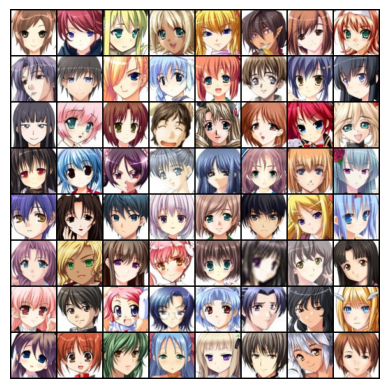

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


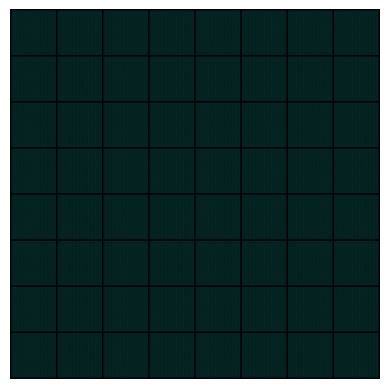

In [18]:
def reconstruct(model, data_loader):
    model.eval()
    
    x = next(iter(data_loader))[0].to(device)
    _, x_recon, _ = model(x)
    
    return x, x_recon

x, x_recon = reconstruct(model, test_loader)
show_images(x.detach().cpu())
show_images(x_recon.detach().cpu())

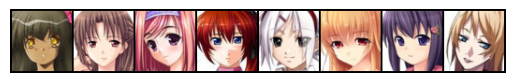

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


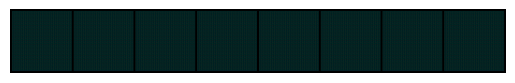

In [20]:
def show_samples(model, data_loader):
    data_loader = DataLoader(test_dataset, batch_size=8, shuffle=True)
    
    model.eval()
    
    x, _ = next(iter(data_loader))
    x = x.to(device)
    _, x_recon, _ = model(x)
    
    show_images(x.detach().cpu())
    show_images(x_recon.detach().cpu())
    
show_samples(model, test_loader)